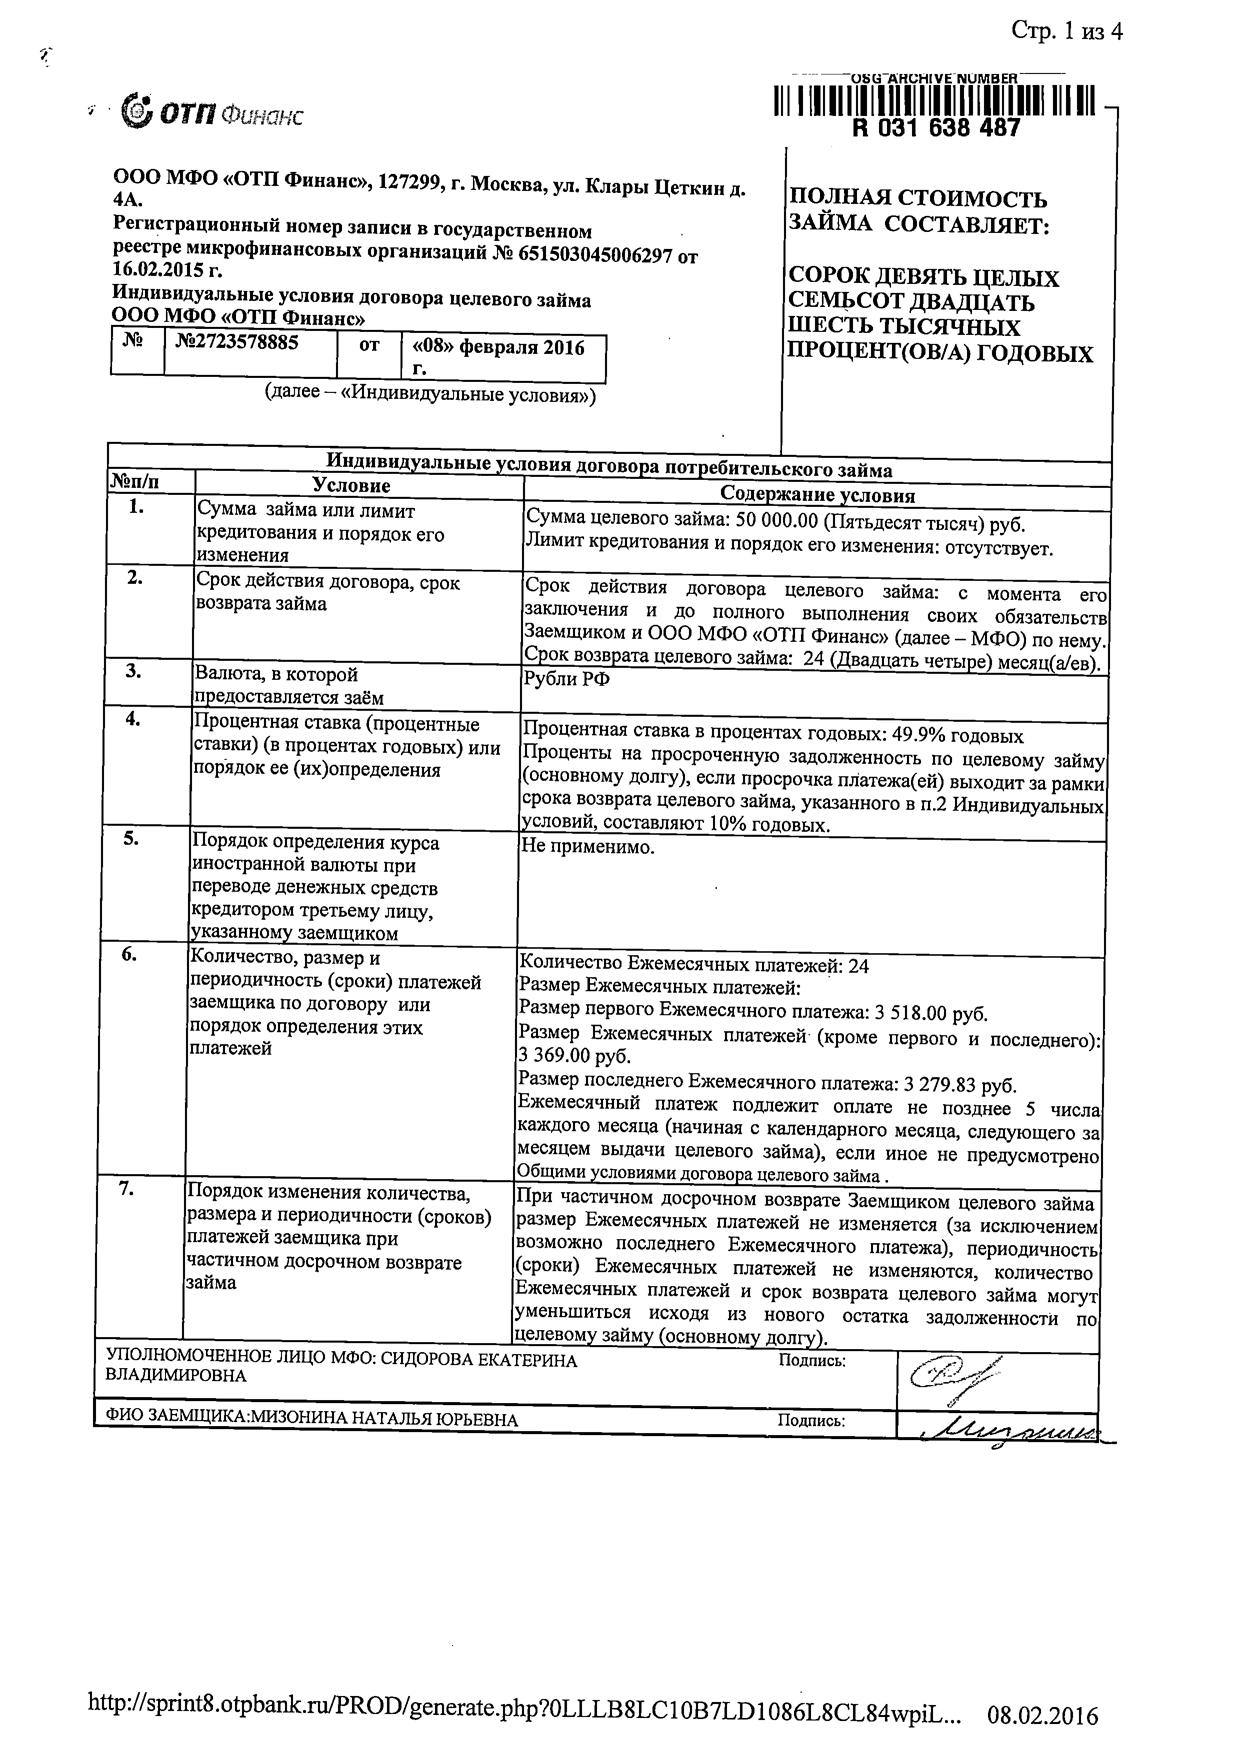

In [50]:
import os.path

from PIL import Image

file_path = r"C:\Users\tigra\PycharmProjects\OcrResearch\data\fifo1\FIO_1_page-0001.jpg"
# file_path = r"C:\Users\tigra\PycharmProjects\OcrResearch\data\fifo_normalize\FIO_1_page-0001.jpg"
# file_path = r"C:\Users\tigra\PycharmProjects\OcrResearch\data\pos_credit2\pos_credit_2_page-0001.jpg"
# file_path = r"C:\Users\tigra\PycharmProjects\OcrResearch\data\dev\pos_1_1_gaussian.jpg" # only noise reduction
# file_path = r"C:\Users\tigra\PycharmProjects\OcrResearch\data\dev\pos_1_1_unpaper_noise.jpg" # only noise reduction
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width * 0.5), int(height * 0.5)))

In [51]:
from transformers import AutoImageProcessor, TableTransformerForObjectDetection

import torch

image_processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-detection")
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

inputs = image_processor(images=image, return_tensors="pt")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

In [52]:
outputs = model(**inputs)

In [53]:
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]

In [54]:
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]

    print(

        f"Detected {model.config.id2label[label.item()]} with confidence "

        f"{round(score.item(), 3)} at location {box}"

    )

Detected table with confidence 0.973 at location [220.93, 897.98, 2207.68, 2818.05]


[220.93, 897.98, 2207.68, 2818.05]


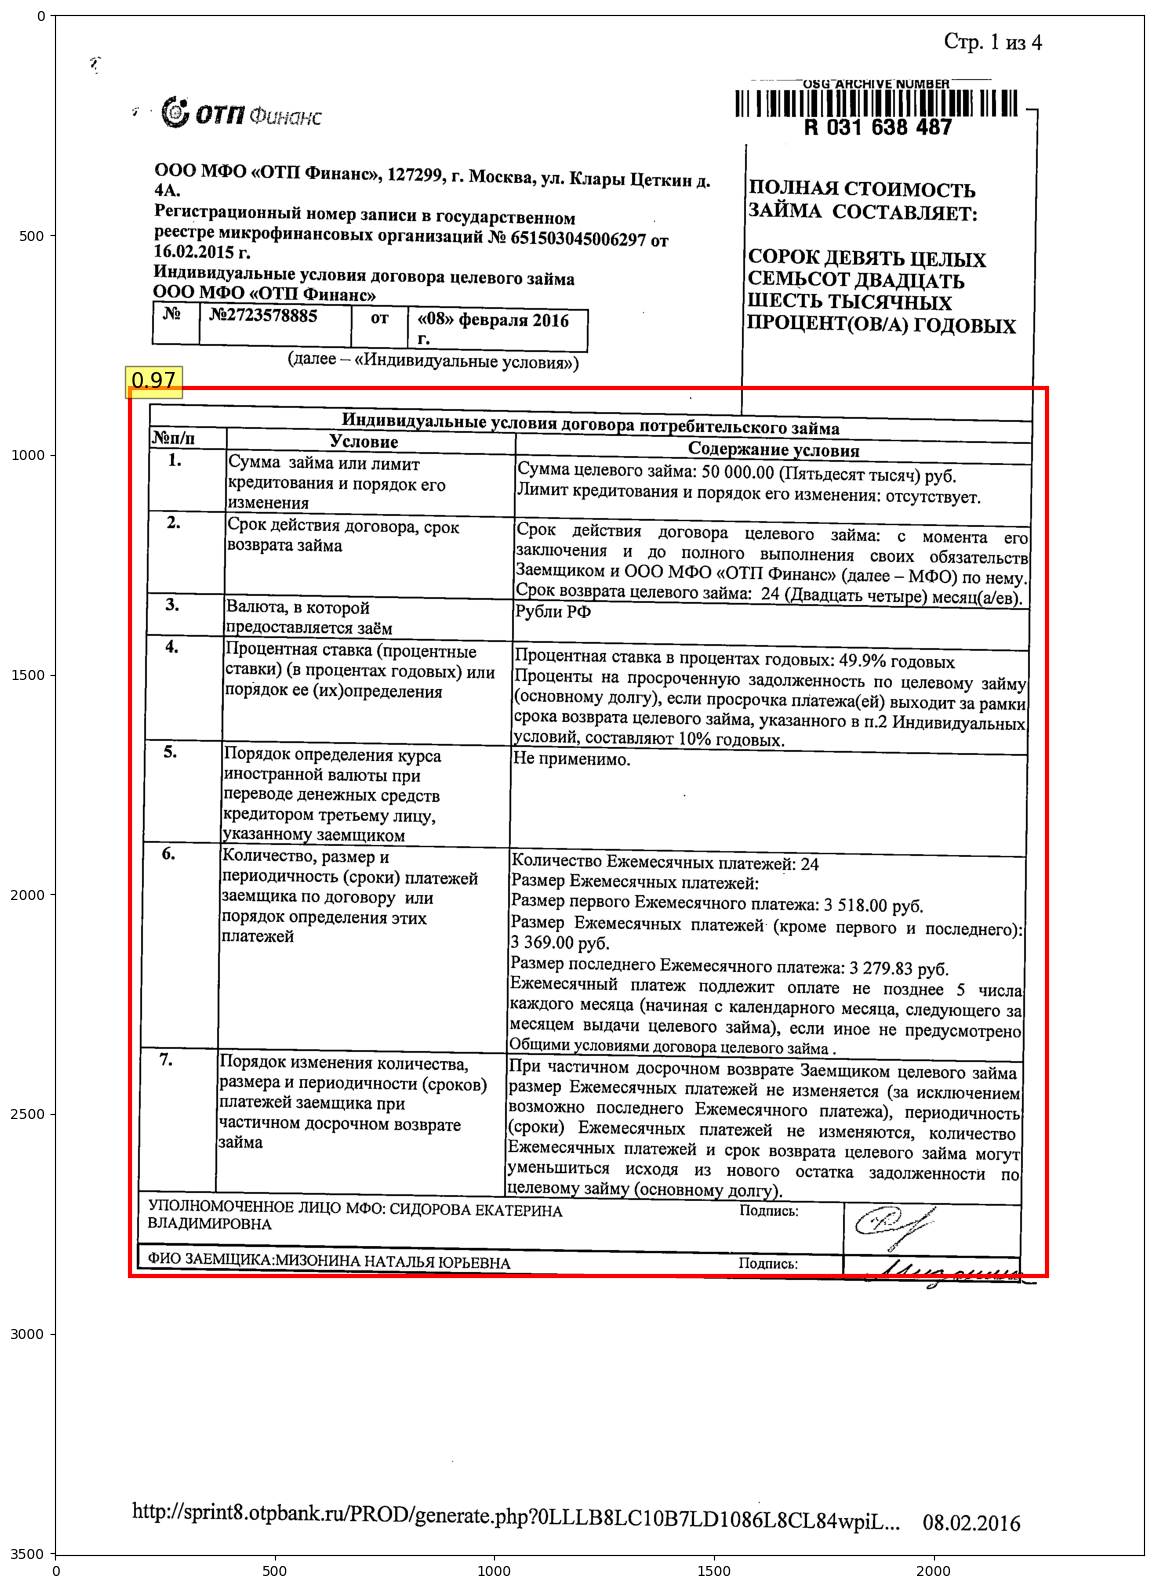

In [55]:
from matplotlib import pyplot as plt

colors = ["red", "blue", "green", "yellow", "orange", "violet"]


def plot_results(pil_img, prob, boxes, labels):
    plt.figure(figsize=(32, 20))
    plt.imshow(pil_img)
    ax = plt.gca()
    # for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
    for p, coord in zip(prob, boxes):
        # box = [round(i, 2) for i in boxes.tolist()]
        cl = p.argmax()
        box = [round(i, 2) for i in coord.tolist()]
        xmin, ymin, xmax, ymax = box
        xmin += 00
        padding = 50
        xmax += padding
        ymax += padding
        xmin -= padding
        ymin -= padding
        # p=round(xmin,2)
        print(box)
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=colors[cl.item()], linewidth=3))
        cl.item()
        # text = f'{model.config.id2label[cl.item()]}: {p[cl]:0.2f}'
        text = f'{float(p):0.2f}'

        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    # plt.axis('off')
    plt.show()


plot_results(image, results["scores"], results["boxes"], results["labels"])


tensor([[ 220.9302,  897.9847, 2207.6772, 2818.0510]],
       grad_fn=<IndexBackward0>)


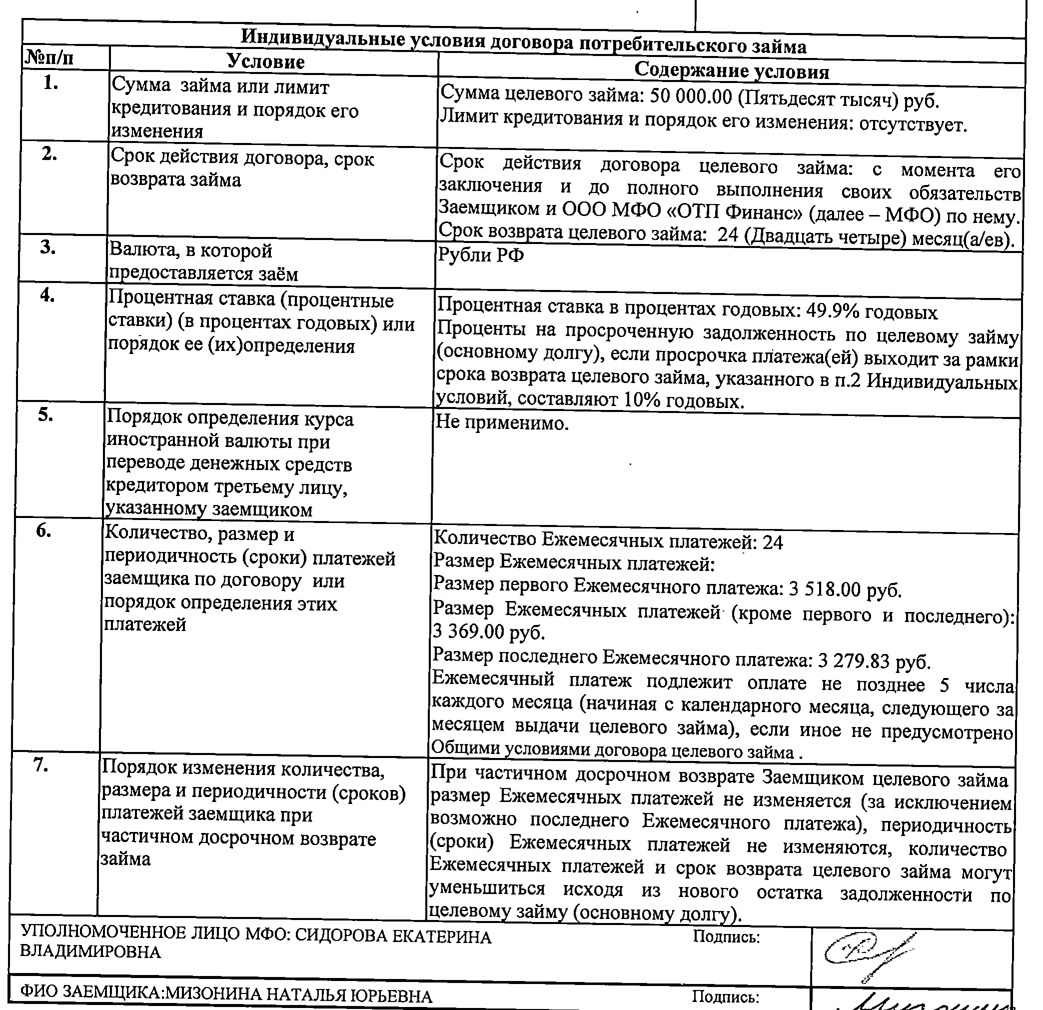

In [56]:
print(results["boxes"])
xmin, ymin, xmax, ymax = results["boxes"].tolist()[0]
padding = 50
xmax += padding
ymax += padding
xmin -= padding
ymin -= padding
crop_img = image.crop((xmin, ymin, xmax, ymax))
width, height = crop_img.size
crop_img.resize((int(width * 0.5), int(height * 0.5)))

In [57]:
from transformers import AutoFeatureExtractor, AutoModelForObjectDetection

extractor = AutoFeatureExtractor.from_pretrained("microsoft/table-transformer-structure-recognition")
model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")
encoding = extractor(crop_img, return_tensors="pt")
encoding.keys()

C:\Users\tigra\PycharmProjects\OcrResearch\venv_ocr_python\lib\site-packages\transformers\models\detr\feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Table

dict_keys(['pixel_values', 'pixel_mask'])

In [58]:
print(encoding['pixel_values'].shape)


torch.Size([1, 3, 800, 826])


In [59]:
with torch.no_grad():
    outputs = model(**encoding)

In [60]:
import torch

# keep only predictions of queries with 0.9+ confidence (excluding no-object class)
probas = outputs.logits.softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.6

# rescale bounding boxes
target_sizes = torch.tensor(crop_img.size[::-1]).unsqueeze(0)
postprocessed_outputs = extractor.post_process(outputs, target_sizes)
bboxes_scaled_lay = postprocessed_outputs[0]['boxes'][keep]

In [61]:
def plot_results(pil_img, prob, boxes, class_to_show=0):
    plt.figure(figsize=(32, 20))
    plt.imshow(pil_img)
    ax = plt.gca()
    total = 0
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        if cl.item() == class_to_show:
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color=colors[cl.item()], linewidth=3))
            text = f'{model.config.id2label[cl.item()]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
            total += 1
        else:
            continue
    plt.axis('off')
    plt.show()
    print(f"Count entry: {total}")

# plot_results(crop_img, probas[keep], bboxes_scaled_lay, class_to_show=2)
# Нашли row

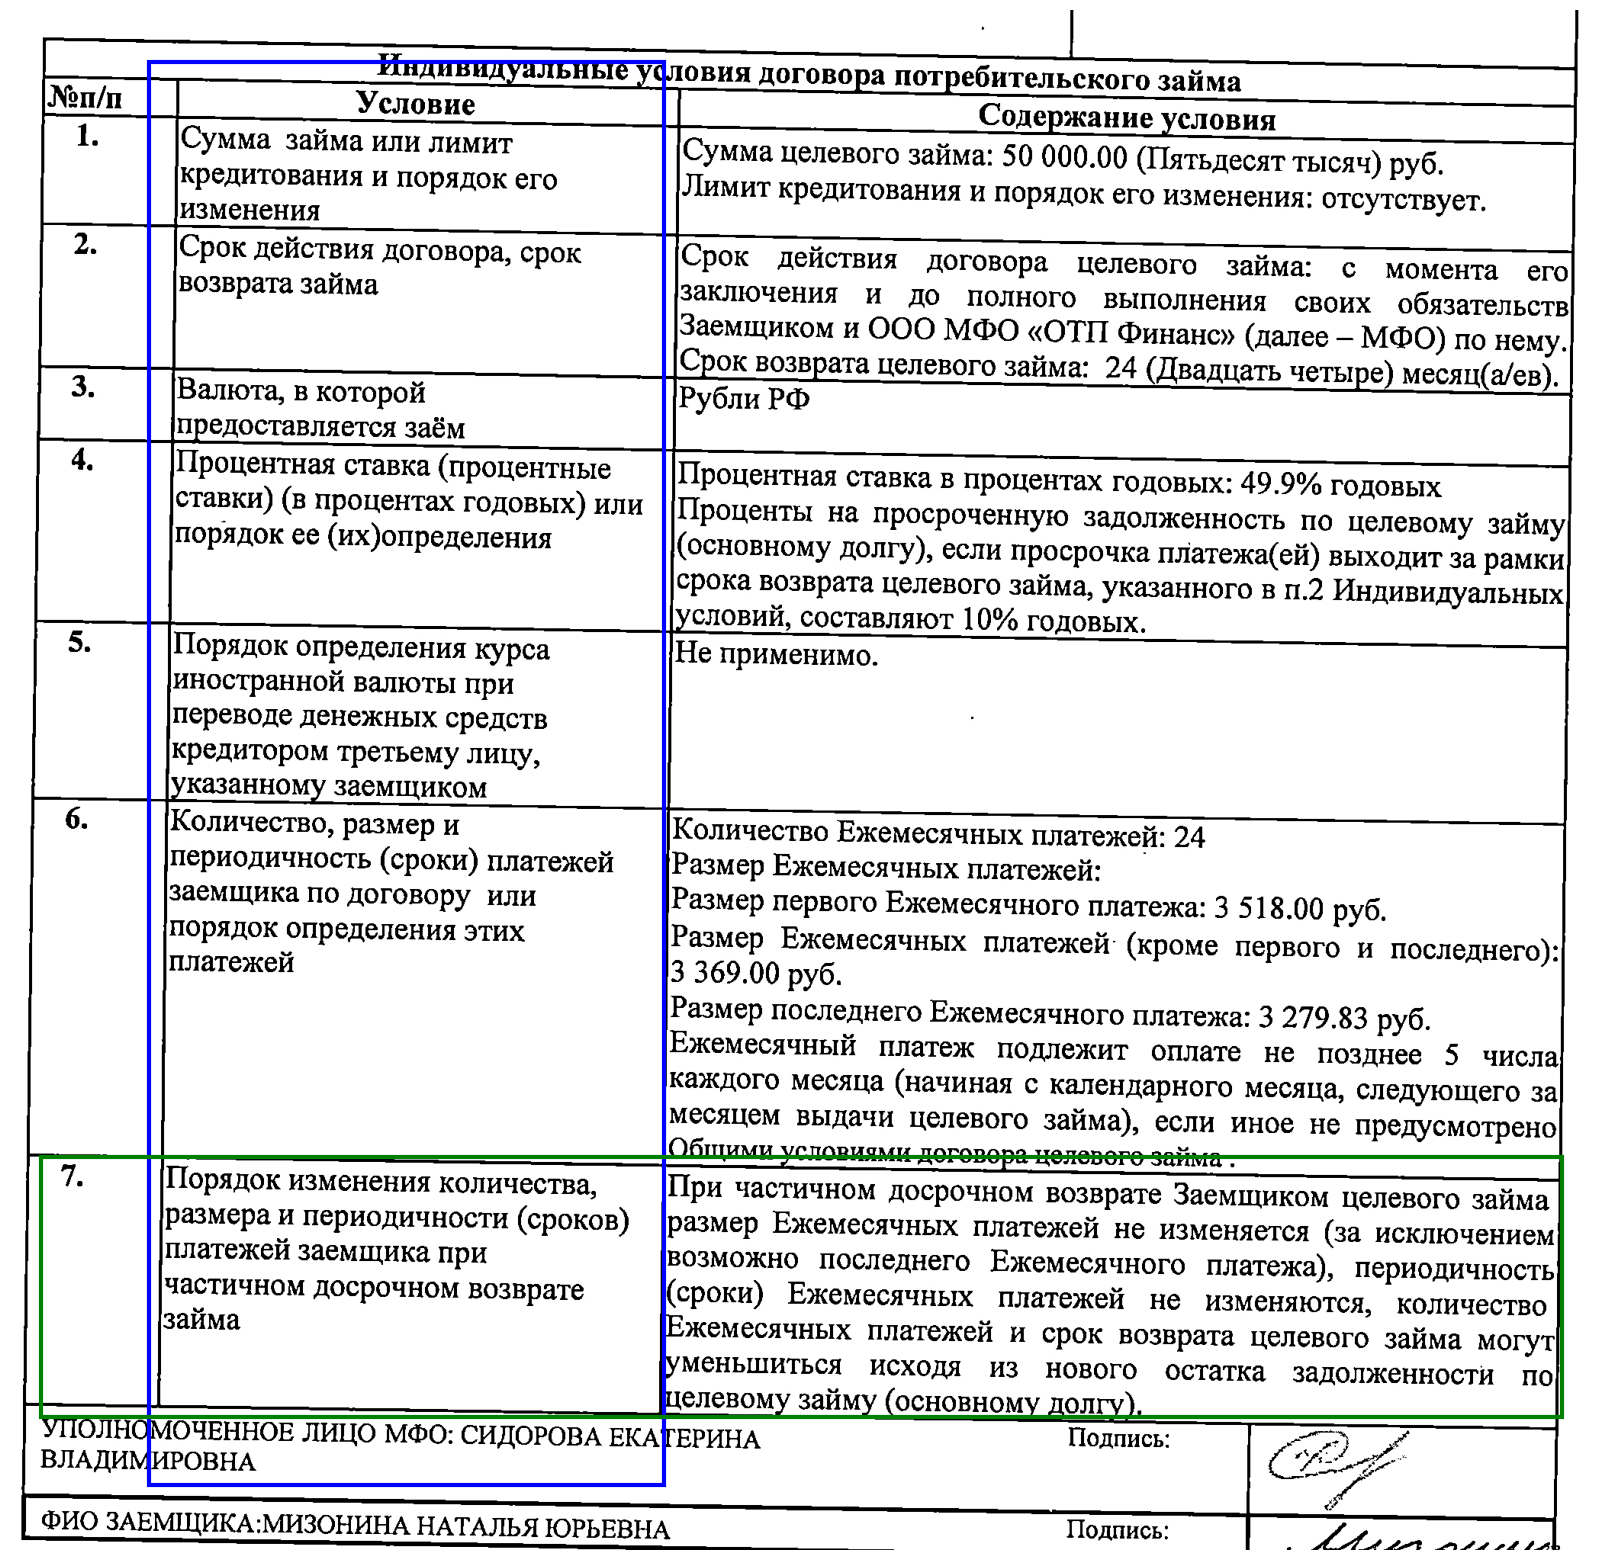

In [62]:
probs_keeping = probas[keep]
boxes = bboxes_scaled_lay
b = 0
for p, (xmin, ymin, xmax, ymax) in zip(probs_keeping, boxes.tolist()):
    # fist_col_coord = (xmin, ymin, xmax, ymax)
    # if b >0:
    #     break
    cl = p.argmax()
    if cl.item() == 1:  # col
        fist_col_coord = (xmin, ymin, xmax, ymax)
        b += 1
        if b > 2:
            break
        # break
for p, (xmin, ymin, xmax, ymax) in zip(probs_keeping, boxes.tolist()):
    cl = p.argmax()
    if cl.item() == 2:  # row
        fist_row_coord = (xmin, ymin, xmax, ymax)
        break
img_dev = crop_img.copy()
plt.figure(figsize=(32, 20))
plt.imshow(img_dev)
ax = plt.gca()
xmin_col, ymin_col, xmax_col, ymax_col = fist_col_coord
ax.add_patch(plt.Rectangle((xmin_col, ymin_col), xmax_col - xmin_col, ymax_col - ymin_col,
                           fill=False, color=colors[1], linewidth=3))  # plot col
xmin_row, ymin_row, xmax_row, ymax_row = fist_row_coord
ax.add_patch(plt.Rectangle((xmin_row, ymin_row), xmax_row - xmin_row, ymax_row - ymin_row,
                           fill=False, color=colors[2], linewidth=3))  # plot row
plt.axis('off')
plt.show()

In [63]:
# plot_results(crop_img, probas[keep], bboxes_scaled_lay, class_to_show=1)
# Так нет, суть в алгоритме после нейронки Не,это норм. по сути мы делаем обрезание,даже если там слегка будет перебор,при работе OCR норм будет

In [64]:
def find_intersection(x1, y1, x2, y2, x3, y3, x4, y4):
    """Finds the intersection of two rectangles.

    Args:
      x1: The x-coordinate of the first rectangle's top-left corner.
      y1: The y-coordinate of the first rectangle's top-left corner.
      x2: The x-coordinate of the first rectangle's bottom-right corner.
      y2: The y-coordinate of the first rectangle's bottom-right corner.
      x3: The x-coordinate of the second rectangle's top-left corner.
      y3: The y-coordinate of the second rectangle's top-left corner.
      x4: The x-coordinate of the second rectangle's bottom-right corner.
      y4: The y-coordinate of the second rectangle's bottom-right corner.

    Returns:
      A tuple of four coordinates (x1, y1, x2, y2) of the intersecting rectangle,
      or None if the two rectangles do not overlap.
    """

    if x1 > x4 or x2 < x3 or y1 > y4 or y2 < y3:
        return None

    x_min = max(x1, x3)
    x_max = min(x2, x4)
    y_min = max(y1, y3)
    y_max = min(y2, y4)

    return x_min, y_min, x_max, y_max

In [65]:
def crop_image(img, xmin, ymin, xmax, ymax):
    return img.crop((xmin, ymin, xmax, ymax))

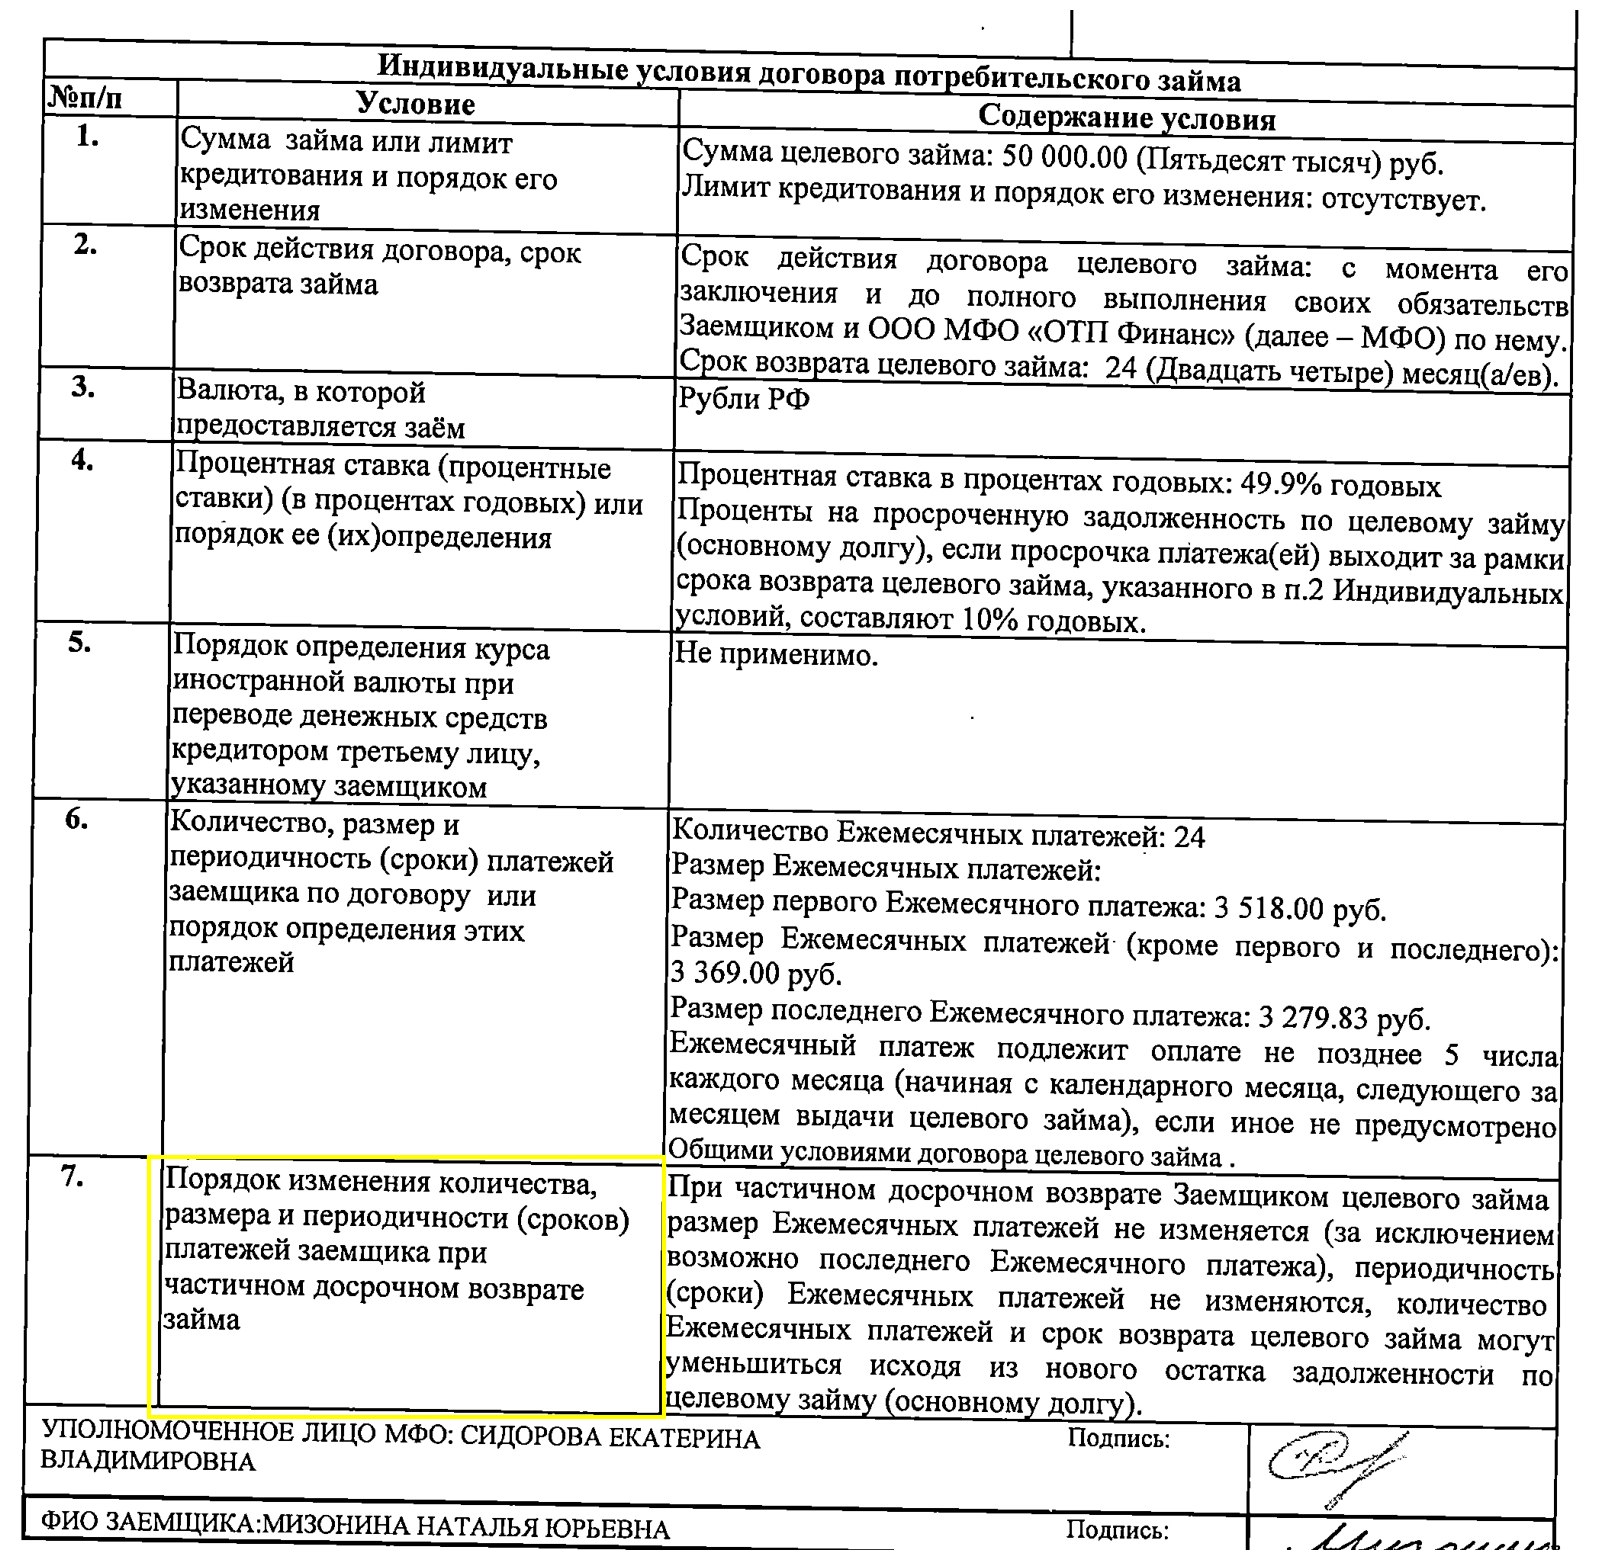

In [66]:
img_dev = crop_img.copy()
plt.figure(figsize=(32, 20))
plt.imshow(img_dev)
ax = plt.gca()
xmin__intr, ymin__intr, xmax__intr, ymax__intr = find_intersection(xmin_row, ymin_row, xmax_row, ymax_row, xmin_col,
                                                                   ymin_col, xmax_col, ymax_col)

ax.add_patch(plt.Rectangle((xmin__intr, ymin__intr), xmax__intr - xmin__intr, ymax__intr - ymin__intr,
                           fill=False, color=colors[3], linewidth=3))  # plot col

plt.axis('off')
plt.show()
# find_intersection(xmin_row, ymin_row, xmax_row, ymax_row, xmin_col, ymin_col, xmax_col, ymax_col)

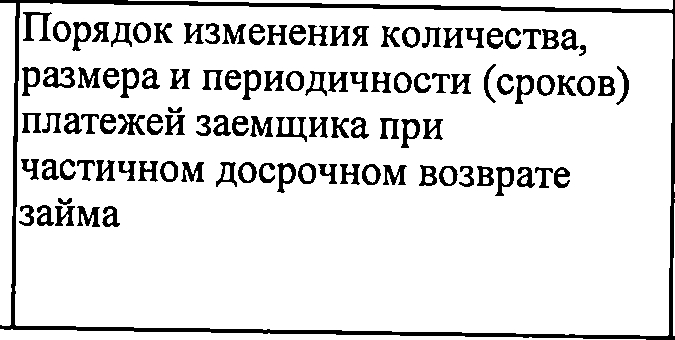

In [67]:
croped_img_text = crop_image(crop_img, xmin__intr, ymin__intr, xmax__intr, ymax__intr)
croped_img_text

In [68]:
from dataclasses import dataclass


@dataclass
class FoundedTableObjects:
    xmin: int
    ymin: int
    xmax: int
    ymax: int
    pos: int  # 1 col 2 rows
    img: any = None

    def set_img(self, img):
        self.img = img


@dataclass
class FoundedCell:
    xmin: int
    ymin: int
    xmax: int
    ymax: int
    img: Image.Image | str = None
    text_tesseract: str = None
    text_easy_ocr: str = None

    def set_img(self, img):
        self.img = img

    def set_text_tesseract(self, text):
        self.text_tesseract = text

    def set_text_easy_ocr(self, text):
        text = [data_found[1] for data_found in text]
        text = "".join(text)
        self.text_easy_ocr = text

    def save_image(self, name):
        save_name = f"{name}.jpg"
        self.img.save(save_name)
        self.img = save_name

# cropped_img_cls = FoundedTableObjects(xmin__intr, ymin__intr, xmax__intr, ymax__intr)


In [69]:
probs_keeping = probas[keep]
boxes = bboxes_scaled_lay
rows_data: list[FoundedTableObjects] = []
cols_data: list[FoundedTableObjects] = []
for p, (xmin, ymin, xmax, ymax) in zip(probs_keeping, boxes.tolist()):
    # fist_col_coord = (xmin, ymin, xmax, ymax)
    # if b >0:
    #     break
    cl = p.argmax()
    pos = cl.item()
    if pos == 1 or pos == 2:
        cropped_img_inst = FoundedTableObjects(xmin, ymin, xmax, ymax, pos)
        crop_img_founded_table_obj = crop_image(crop_img, xmin, ymin, xmax, ymax)
        cropped_img_inst.set_img(crop_img_founded_table_obj)
        if pos == 1:  # col
            cols_data.append(cropped_img_inst)
        elif pos == 2:  # rows
            rows_data.append(cropped_img_inst)
    # if cl.item() == 1:  # col
    # fist_col_coord = (xmin, ymin, xmax, ymax)
    # if cl.item() == 2:
    #     rows_data.append(CroppedImg(xmin, ymin, xmax, ymax, 2))


In [70]:
founded_cells: list[FoundedCell] = []
for columns in cols_data:
    for rows in rows_data:
        xmin_inter, ymin_inter, xmax_inter, ymax_inter = find_intersection(columns.xmin, columns.ymin, columns.xmax,
                                                                           columns.ymax, rows.xmin, rows.ymin,
                                                                           rows.xmax,
                                                                           rows.ymax)
        img_d = crop_image(crop_img, xmin_inter, ymin_inter, xmax_inter, ymax_inter)
        cell = FoundedCell(xmin_inter, ymin_inter, xmax_inter, ymax_inter)
        cell.set_img(img_d)
        founded_cells.append(cell)

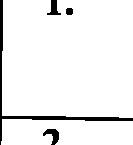

In [71]:
founded_cells[3].img

In [72]:
import pytesseract
import easyocr
import numpy as np

tesseract_path = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
pytesseract.pytesseract.tesseract_cmd = tesseract_path


def use_tesseract(img):
    text = pytesseract.image_to_string(img, lang='rus')
    return text


def use_easy_ocr_eng_rus(img):
    reader = easyocr.Reader(['ru', 'en'], gpu=False)  # this needs to run only once to load the model into memory
    result = reader.readtext(img)
    return result


def convert_pil2numpy(pil_img) -> np.array:
    image_numpy = np.array(pil_img)
    return image_numpy


Using CPU. Note: This module is much faster with a GPU.


Tesseract text: 
Easy ocr text : [([[24, 8], [54, 8], [54, 42], [24, 42]], '7.', 0.8848280591123608)]


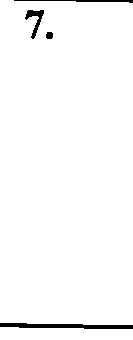

In [73]:
img_used = founded_cells[0].img
text = use_tesseract(img_used)
print(f"Tesseract text: {text}")
img_np = convert_pil2numpy(img_used)
text = use_easy_ocr_eng_rus(img_np)
# text = text[0][1]
print(f"Easy ocr text : {text}")
img_used

In [74]:
for cell in founded_cells:
    text_tesseract = use_tesseract(cell.img)
    cell.set_text_tesseract(text_tesseract)
    img_np = convert_pil2numpy(cell.img)
    text_easy = use_easy_ocr_eng_rus(img_np)
    cell.set_text_easy_ocr(text_easy)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with

In [75]:
type(cell.img)

PIL.Image.Image

In [76]:
import json
from dataclasses import asdict

img_counter = 0


class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, FoundedCell):
            return super().default(obj)
        if isinstance(obj, Image.Image):
            name = f"img_save{img_counter}.jpg"
            obj.save(name)
            return name
        return super().default(obj)


base_name_count = 0
name = "cell_img_"
for cell in founded_cells:
    save_name = f"{name}{base_name_count}"
    cell.save_image(save_name)
    base_name_count += 1
res = [asdict(cell) for cell in founded_cells]
# json_str = json.dumps(founded_cells, cls=MyEncoder)

In [77]:
json_data = json.dumps(res, ensure_ascii=False).encode('utf8')

In [78]:
with open("my_json_cells.json", "w", encoding="utf8") as json_file:
    json.dump(res, json_file, ensure_ascii=False)

In [79]:
res[15]

{'xmin': 859.482666015625,
 'ymin': 812.22216796875,
 'xmax': 2037.208251953125,
 'ymax': 1044.3743896484375,
 'img': 'cell_img_15.jpg',
 'text_tesseract': '',
 'text_easy_ocr': 'He применимо'}

In [80]:
def sort_by_y(cells: list[FoundedCell]):
    return sorted(cells, key=lambda cell: cell.ymin)


def sort_by_x(cells: list[FoundedCell]):
    return sorted(cells, key=lambda cell: cell.xmin)


sorted_by_row = sort_by_y(founded_cells)

In [81]:
col_len = len(cols_data)
list_of_lists = []
for i in range(0, len(sorted_by_row), col_len):
    # row = sorted_by_row[i:i + col_len]
    row = sort_by_x(sorted_by_row[i:i + col_len])
    res_row = []
    for r in row:
        res_text = r.text_tesseract
        if not res_text:
            res_text = r.text_easy_ocr
        res_row.append(res_text)
    list_of_lists.append(res_row)

In [82]:
import pandas as pd

df = pd.DataFrame(list_of_lists, columns=[f"generic_name_{i}" for i in range(0, col_len)])
print(df)

    generic_name_0                                     generic_name_1  \
0                   умма заима или лимит\nкредитования и порядок е...   
1                     рек дбиствия договора, срок\nвозврата займа\n\n   
2               3.          Валюта, в которой\nпредоставляется заём\n   
3             ч.\n  ‚зроцентная ставка (процентные\nставки) (в про...   
4                5  Порядок определения курса\nиностранной валюты ...   
5               6.  Количество, размер и\nпериодичность (сроки) пл...   
6               7.  Порядок изменения количества,\nразмера и перио...   
7  УПОЛНС\nВЛАДИ\n  О [|[|Ьь-  ьнхьЪ\nМОЧЕННОЕ ЛИЦО МФО: СИДОРОВА ...   

                                      generic_name_2  
0  Сумма целевого займа: 50 000.00 (Пятьдесят тыс...  
1  Срок действия договора целевого займа: с момен...  
2                       о МИ РА Ао АМ 1 АР мА си У\n  
3  Процентная ставка в процентах годовых: 49.9% г...  
4                                       He применимо  
5  Количеств

In [83]:
json_df = df.to_json(force_ascii=False)
print(json_df)

{"generic_name_0":{"0":"","1":"","2":"3.","3":"ч.\n","4":"5","5":"6.","6":"7.","7":"УПОЛНС\nВЛАДИ\n"},"generic_name_1":{"0":"умма заима или лимит\nкредитования и порядок его\n\n","1":"рек дбиствия договора, срок\nвозврата займа\n\n","2":"Валюта, в которой\nпредоставляется заём\n","3":"‚зроцентная ставка (процентные\nставки) (в процентах годовых) или\nпорядок ее (их)определения\n","4":"Порядок определения курса\nиностранной валюты при\n\nпереводе денежных средств\nкредитором третьему лицу,\n\n","5":"Количество, размер и\nпериодичность (сроки) платежей\nзаемщика по договору или\nпорядок определения этих\nплатежей\n","6":"Порядок изменения количества,\nразмера и периодичности (сроков)\nплатежей заемщика при\nчастичном досрочном возврате\nзайма\n\n","7":"О [|[|Ьь-  ьнхьЪ\nМОЧЕННОЕ ЛИЦО МФО: СИДОРОВА ЕКА:\nИРОВНА\n"},"generic_name_2":{"0":"Сумма целевого займа: 50 000.00 (Пятьдесят тысяч) руб.\nЛимит кредитования и порядок его изменения: отсутствует.\n\n","1":"Срок действия договора целевог

In [84]:
import os
base_file_name = os.path.basename(file_path)
base_file_name_without_ext = os.path.splitext(base_file_name)[0]
file_name2save = base_file_name_without_ext + ".csv"


In [85]:
df.to_csv(base_file_name_without_ext+".csv")
with open(f"{base_file_name_without_ext}.json", "w") as outfile:
    outfile.write(json_df)